In [1]:
import numpy as np
import pandas as pd
import glob
import requests
from bs4 import BeautifulSoup
import re
import sklearn.linear_model
import matplotlib.pyplot as plt
from ipyleaflet import Map, Polyline

%matplotlib notebook
pd.set_option('display.max_columns', 500)

### Téléchargement des excel

In [2]:
URL = 'https://www.vendeeglobe.org/fr/classement'

def extract_vendeeglobe(url):
    r = requests.get(url)
    content = r.content.decode('utf-8')
    soup = BeautifulSoup(content)
    dropdown_list = soup.find('select', {'class': 'form__input m--select onsubmit-rank'}).findChildren("option" , recursive=False)
    list_url = []
    list_name = []
    for option in dropdown_list:
        if option['value'] != '':
            list_url.append(url.split('/fr')[0] + '/download-race-data/vendeeglobe_' + option['value'] + '.xlsx')
            list_name.append('vendeeglobe_' + option['value'] + '.xlsx')
    return list(zip(list_url, list_name))


def download_vendeeglobe(url):
    list_excel = extract_vendeeglobe(url)
    for url, name in list_excel:
        r = requests.get(url)
        with open('files/' + name, 'wb') as output:
            output.write(r.content)

In [3]:
download_vendeeglobe(url=URL)

### Correction d'un bug de lecture de pandas lié à une variable xxid présent dans les excel

In [4]:
# Code réalisé par Alexandre Le Bris pour régler un problème lié à 'xxid' 
# lors de la lecture des fichiers excel par pandas
import tempfile
from zipfile import ZipFile
import shutil
import os
from fnmatch import fnmatch
import re

def change_in_zip(file_name, name_filter, change):
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)           
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)

def change_all():
    for filename in glob.glob('files/*'):
        change_in_zip(filename, name_filter='xl/styles.xml', change=lambda d: re.sub(b'xxid="\d*"', b"", d))

In [5]:
change_all()

### Lecture, tri et nettoyage des fichiers Excel

In [6]:
map_arv = {1:'Rang', 2:'Nationalité', 3:'Participant', 7:'Date d\'arrivée', 8:'Temps de course', \
           13:'Ecart (Au premiers)', 15:'Ecart (Au précédent)', 16:'Vitesse en kts (Sur l\'ortho)', \
           17:'Distance en nm (Sur l\'ortho)', 18:'► en %', 19:'Vitesse en kts (Sur le fond)', \
           20:'Distance en nm (Sur le fond)'}

map_run = {1: 'Rang', 2: 'Nationalité', 3: 'Participant', 4: 'Heure FR', 5: 'Latitude', 6: 'Longitude', \
           7: 'Cap en degré (30 min)', 8: 'Vitesse en kts (30 min)', 9: 'VMG en kts (30 min)', \
           10: 'Distance en nm (30 min)', 11: 'Cap en degré (Dernier class.)', 12: 'Vitesse en kts (Dernier class.)', \
           13: 'VMG en kts (Dernier class.)', 14: 'Distance en nm (Dernier class.)', 15: 'Cap en degré (24h)', \
           16: 'Vitesse en kts (24h)', 17: 'VMG en kts (24h)', 18: 'Distance en nm (24h)', 19: 'DTF en nm', \
           20: 'DTL en nm'}

map_abd = {1:'Rang', 2:'Nationalité', 3:'Participant'}

In [7]:
def get_df_arv(df_init, map_arv):
    df_arv = df_init[df_init[1].str.contains('ARV')]
    df_arv = df_arv.drop([4, 5, 6, 9, 10, 11, 12, 14], axis=1)
    df_arv = df_arv.rename(columns=map_arv)
    
    df_arv['Rang'] = df_arv['Rang'].str.extract("(.*)\n")
    
    df_arv['Date d\'arrivée'] = df_arv['Date d\'arrivée'].str.extract("(.*) FR")
    df_arv['Date d\'arrivée'] = pd.to_datetime(df_arv['Date d\'arrivée'], format='%d/%m/%Y %H:%M:%S')
    
    df_arv['Temps précédent'] = df_arv['Temps de course'].str.extract("\n(.*)")
    df_arv['Temps précédent'] = df_arv['Temps précédent'].apply(lambda x: str(x).replace('j', 'd'))
    df_arv['Temps précédent'] = df_arv['Temps précédent'].apply(lambda x: pd.Timedelta(x))
    
    df_arv['Temps de course'] = df_arv['Temps de course'].str.extract("(.*)\n")
    df_arv['Temps de course'] = df_arv['Temps de course'].apply(lambda x: str(x).replace('j', 'd'))
    df_arv['Temps de course'] = df_arv['Temps de course'].apply(lambda x: pd.Timedelta(x))
    
    df_arv.loc[0, 'Ecart (Au premiers)'] = pd.Timedelta(0)
    df_arv.loc[1:, 'Ecart (Au premiers)'] = df_arv.loc[1:, 'Ecart (Au premiers)'].apply(lambda x: str(x).replace('j', 'd'))
    df_arv.loc[1:, 'Ecart (Au premiers)'] = df_arv.loc[1:, 'Ecart (Au premiers)'].apply(lambda x: pd.Timedelta(x))
    
    df_arv.loc[0, 'Ecart (Au précédent)'] = pd.Timedelta(0)
    df_arv.loc[1:, 'Ecart (Au précédent)'] = df_arv.loc[1:, 'Ecart (Au précédent)'].apply(lambda x: str(x).replace('j', 'd'))
    df_arv.loc[1:, 'Ecart (Au précédent)'] = df_arv.loc[1:, 'Ecart (Au précédent)'].apply(lambda x: pd.Timedelta(x)) 
    
    df_arv['Vitesse en kts (Sur l\'ortho)'] = df_arv['Vitesse en kts (Sur l\'ortho)'].str.extract("(.*) kts")
    df_arv['Vitesse en kts (Sur l\'ortho)'] = df_arv['Vitesse en kts (Sur l\'ortho)'].apply(lambda x: float(x))
    
    df_arv['Distance en nm (Sur l\'ortho)'] = df_arv['Distance en nm (Sur l\'ortho)'].str.extract("(.*) nm")
    df_arv['Distance en nm (Sur l\'ortho)'] = df_arv['Distance en nm (Sur l\'ortho)'].apply(lambda x: float(x))
    
    df_arv['Vitesse en kts (Sur le fond)'] = df_arv['Vitesse en kts (Sur le fond)'].str.extract("(.*) kts")
    df_arv['Vitesse en kts (Sur le fond)'] = df_arv['Vitesse en kts (Sur le fond)'].apply(lambda x: float(x))
    
    df_arv['Distance en nm (Sur le fond)'] = df_arv['Distance en nm (Sur le fond)'].str.extract("(.*) nm")
    df_arv['Distance en nm (Sur le fond)'] = df_arv['Distance en nm (Sur le fond)'].apply(lambda x: float(x))
    
    df_arv['► en %'] = df_arv['► en %'].str.extract("(.*) %")
    df_arv['► en %'] = df_arv['► en %'].apply(lambda x: float(x))
    
    df_arv['Statut'] = 'Arrivé'
    
    return df_arv

In [8]:
def degmin_to_dec(x):
    degree, minute, direction =  re.split('[°\'"]', x)
    return (float(degree) + float(minute)/60) * (1 if direction in ['N', 'E'] else -1)

def get_df_run(df_init, map_run):
    df_run = df_init[df_init[1].str.isnumeric()]
    df_run = df_run.rename(columns=map_run)
    df_run = df_run.drop(['Heure FR'], axis=1)
    
    df_run['Latitude'] = df_run['Latitude'].apply(degmin_to_dec)
    df_run['Longitude'] = df_run['Longitude'].apply(degmin_to_dec)
    
    df_run['Cap en degré (30 min)'] = df_run['Cap en degré (30 min)'].str.extract("(.*)°")
    df_run['Cap en degré (30 min)'] = df_run['Cap en degré (30 min)'].apply(lambda x: int(x))
    
    df_run['Vitesse en kts (30 min)'] = df_run['Vitesse en kts (30 min)'].str.extract("(.*) kts")
    df_run['Vitesse en kts (30 min)'] = df_run['Vitesse en kts (30 min)'].apply(lambda x: float(x))
    
    df_run['VMG en kts (30 min)'] = df_run['VMG en kts (30 min)'].str.extract("(.*) kts")
    df_run['VMG en kts (30 min)'] = df_run['VMG en kts (30 min)'].apply(lambda x: float(x))
    
    df_run['Distance en nm (30 min)'] = df_run['Distance en nm (30 min)'].str.extract("(.*) nm")
    df_run['Distance en nm (30 min)'] = df_run['Distance en nm (30 min)'].apply(lambda x: float(x))
    
    df_run['Cap en degré (Dernier class.)'] = df_run['Cap en degré (Dernier class.)'].str.extract("(.*)°")
    df_run['Cap en degré (Dernier class.)'] = df_run['Cap en degré (Dernier class.)'].apply(lambda x: int(x))
    
    df_run['Vitesse en kts (Dernier class.)'] = df_run['Vitesse en kts (Dernier class.)'].str.extract("(.*) kts")
    df_run['Vitesse en kts (Dernier class.)'] = df_run['Vitesse en kts (Dernier class.)'].apply(lambda x: float(x))
    
    df_run['VMG en kts (Dernier class.)'] = df_run['VMG en kts (Dernier class.)'].str.extract("(.*) kts")
    df_run['VMG en kts (Dernier class.)'] = df_run['VMG en kts (Dernier class.)'].apply(lambda x: float(x))
    
    df_run['Distance en nm (Dernier class.)'] = df_run['Distance en nm (Dernier class.)'].str.extract("(.*) nm")
    df_run['Distance en nm (Dernier class.)'] = df_run['Distance en nm (Dernier class.)'].apply(lambda x: float(x))
    
    df_run['Cap en degré (24h)'] = df_run['Cap en degré (24h)'].str.extract("(.*)°")
    df_run['Cap en degré (24h)'] = df_run['Cap en degré (24h)'].apply(lambda x: int(x))
    
    df_run['Vitesse en kts (24h)'] = df_run['Vitesse en kts (24h)'].str.extract("(.*) kts")
    df_run['Vitesse en kts (24h)'] = df_run['Vitesse en kts (24h)'].apply(lambda x: float(x))
    
    df_run['VMG en kts (24h)'] = df_run['VMG en kts (24h)'].str.extract("(.*) kts")
    df_run['VMG en kts (24h)'] = df_run['VMG en kts (24h)'].apply(lambda x: float(x))
    
    df_run['Distance en nm (24h)'] = df_run['Distance en nm (24h)'].str.extract("(.*) nm")
    df_run['Distance en nm (24h)'] = df_run['Distance en nm (24h)'].apply(lambda x: float(x))
    
    df_run['DTF en nm'] = df_run['DTF en nm'].str.extract("(.*) nm")
    df_run['DTF en nm'] = df_run['DTF en nm'].apply(lambda x: float(x))
    
    df_run['DTL en nm'] = df_run['DTL en nm'].str.extract("(.*) nm")
    df_run['DTL en nm'] = df_run['DTL en nm'].apply(lambda x: float(x))
    
    df_run['Statut'] = 'En cours'
    return df_run

In [9]:
def get_df_abd(df_init, map_abd):
    df_abd = df_init[df_init[1].str.contains('RET')]
    df_abd = df_abd[[1, 2, 3]]
    df_abd = df_abd.rename(columns=map_abd)
    df_abd['Rang'] = 999
    df_abd['Statut'] = 'Abandonné'
    return df_abd

In [10]:
def get_df_final(df_init, map_arv, map_run, map_abd, filename):
    df_arv = get_df_arv(df_init=df_init, map_arv=map_arv)
    df_run = get_df_run(df_init=df_init, map_run=map_run)
    df_abd = get_df_abd(df_init=df_init, map_abd=map_abd)
    
    df_final = pd.concat([df_arv, df_run, df_abd])
    df_final = df_final[df_final['Rang'].notna()]
    df_final[['Participant', 'Bateau']] = df_final['Participant'].str.extract("(.*)\n(.*)")
    df_final['Rang'] = df_final['Rang'].apply(lambda x: int(x))
    df_final['Nationalité'] = df_final['Nationalité'].str.extract("\n(.*) ")
    df_final['Date'] = pd.to_datetime(re.search('(?<=vendeeglobe_)(.*)(?=.xlsx)', filename).group(1), format='%Y%m%d_%H%M%S')
    return df_final

### Combinaison de tous les fichiers Excel en 1 seul

In [11]:
def combine_df(map_arv, map_run, map_abd):
    list_df = []
    for filename in glob.glob('files/*'):
        df_init = pd.read_excel(filename, header=None, skiprows=5, usecols=range(1,21), dtype=str)
        df_init = df_init[df_init[1].notna()]
        list_df.append(get_df_final(df_init=df_init, map_arv=map_arv, map_run=map_run, map_abd=map_abd, filename=filename))
    df_all = pd.concat(list_df)
    df_all = df_all.sort_values(by=['Date', 'Rang'], ascending=[True, True])
    df_all.to_excel('output.xlsx', index=False)

In [12]:
combine_df(map_arv=map_arv, map_run=map_run, map_abd=map_abd)

In [13]:
output = pd.read_excel('output.xlsx')
output.head()

,Rang,Nationalité,Participant,Date d'arrivée,Temps de course,Ecart (Au premiers),Ecart (Au précédent),Vitesse en kts (Sur l'ortho),Distance en nm (Sur l'ortho),► en %,Vitesse en kts (Sur le fond),Distance en nm (Sur le fond),Temps précédent,Statut,Latitude,Longitude,Cap en degré (30 min),Vitesse en kts (30 min),VMG en kts (30 min),Distance en nm (30 min),Cap en degré (Dernier class.),Vitesse en kts (Dernier class.),VMG en kts (Dernier class.),Distance en nm (Dernier class.),Cap en degré (24h),Vitesse en kts (24h),VMG en kts (24h),Distance en nm (24h),DTF en nm,DTL en nm,Bateau,Date
0,1,FRA,Louis Burton,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.407667,-1.841333,241.0,17.7,17.5,0.3,357.0,0.0,0.0,2788.0,201.0,0.3,0.3,6.1,24293.9,0.0,Bureau Vallée 2,2020-11-08 14:00:00
1,2,MON,Boris Herrmann,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.405667,-1.830333,241.0,11.1,10.9,0.4,357.0,0.0,0.0,2787.9,196.0,0.3,0.2,6.0,24294.2,0.4,Seaexplorer - Yacht Club De Monaco,2020-11-08 14:00:00
2,3,FRA,Jérémie Beyou,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.415167,-1.833167,244.0,15.5,15.5,0.5,357.0,0.0,0.0,2788.5,199.0,0.2,0.2,5.5,24294.3,0.5,Charal,2020-11-08 14:00:00
3,4,FRA,Thomas Ruyant,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.411833,-1.828000,244.0,13.2,13.1,0.7,357.0,0.0,0.0,2788.3,196.0,0.2,0.2,5.6,24294.5,0.6,LinkedOut,2020-11-08 14:00:00
4,5,FRA,Maxime Sorel,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.409833,-1.826000,246.0,10.9,10.9,0.2,357.0,0.0,0.0,2788.1,195.0,0.8,0.7,5.8,24294.5,0.6,V And B Mayenne,2020-11-08 14:00:00


### Obtention des informations des voiliers

In [14]:
reg_nb = r'[-+]?\d*\.\d+|\d+'
reg_word = r':(.*)'

def get_data_sail():
    r = requests.get('https://www.vendeeglobe.org/fr/glossaire')
    content = r.content.decode('utf-8')
    soup = BeautifulSoup(content)
    data_sail = {}
    all_sail = soup.find_all('div', {'class': 'sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6'})
    for sail in all_sail:
        skipper = sail.find('span', {'class': 'boats-list__skipper-name'}).text.title()
        data_sail[skipper] = {}
        all_data = sail.find_all('li')
        for data in all_data:
            if 'Longueur' in data.text:
                data_var = re.findall(reg_nb, data.text.replace(',', '.'))
                if len(data_var) > 0:
                    data_sail[skipper]['Longeur en m'] = data_var[0]
            elif 'Largeur' in data.text:
                data_var = re.findall(reg_nb, data.text.replace(',', '.'))
                if len(data_var) > 0:
                    data_sail[skipper]['Largeur en m'] = data_var[0]
            elif 'Tirant d\'eau' in data.text:
                data_var = re.findall(reg_nb, data.text.replace(',', '.'))
                if len(data_var) > 0:
                    data_sail[skipper]['Tirant d\'eau en m'] = data_var[0]
            elif 'Déplacement (poids)' in data.text:
                data_var = re.findall(reg_nb, data.text.replace(',', '.'))
                if len(data_var) > 0:
                    data_sail[skipper]['Déplacement (poids) en t'] = data_var[0]
            elif 'Nombre de dérives' in data.text:
                data_var = re.findall(reg_word, data.text)
                if len(data_var) > 0:
                    data_sail[skipper]['Nombre de dérives'] = data_var[0].strip()
            elif 'Hauteur mât' in data.text:
                data_var = re.findall(reg_nb, data.text.replace(',', '.'))
                if len(data_var) > 0:
                    data_sail[skipper]['Hauteur mât en m'] = data_var[0]
            elif 'Voile quille' in data.text:
                data_var = re.findall(reg_word, data.text)
                if len(data_var) > 0:
                    data_sail[skipper]['Voile quille'] = data_var[0].strip()
            elif 'Surface de voiles au près' in data.text:
                data_var = re.findall(reg_nb, data.text.replace(',', '.'))
                if len(data_var) > 0:
                    data_sail[skipper]['Surface de voiles au près en m2'] = data_var[0]
            elif 'Surface de voiles au portant' in data.text:
                data_var = re.findall(reg_nb, data.text.replace(',', '.'))
                if len(data_var) > 0:
                    data_sail[skipper]['Surface de voiles au portant en m2'] = data_var[0]
    return data_sail
            

In [15]:
def add_data_sail():
    output = pd.read_excel('output.xlsx')
    data_sail = get_data_sail()
    for skipper, sail in data_sail.items():
        for key, value in sail.items():
            output.loc[output['Participant'] == skipper, key] = value
    output.to_excel('output_with_data.xlsx', index=False)

In [16]:
add_data_sail()

In [17]:
output_with_data = pd.read_excel('output_with_data.xlsx')
output_with_data.head()

,Rang,Nationalité,Participant,Date d'arrivée,Temps de course,Ecart (Au premiers),Ecart (Au précédent),Vitesse en kts (Sur l'ortho),Distance en nm (Sur l'ortho),► en %,Vitesse en kts (Sur le fond),Distance en nm (Sur le fond),Temps précédent,Statut,Latitude,Longitude,Cap en degré (30 min),Vitesse en kts (30 min),VMG en kts (30 min),Distance en nm (30 min),Cap en degré (Dernier class.),Vitesse en kts (Dernier class.),VMG en kts (Dernier class.),Distance en nm (Dernier class.),Cap en degré (24h),Vitesse en kts (24h),VMG en kts (24h),Distance en nm (24h),DTF en nm,DTL en nm,Bateau,Date,Longeur en m,Largeur en m,Tirant d'eau en m,Déplacement (poids) en t,Nombre de dérives,Hauteur mât en m,Voile quille,Surface de voiles au près en m2,Surface de voiles au portant en m2
0,1,FRA,Louis Burton,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.407667,-1.841333,241.0,17.7,17.5,0.3,357.0,0.0,0.0,2788.0,201.0,0.3,0.3,6.1,24293.9,0.0,Bureau Vallée 2,2020-11-08 14:00:00,18.28,5.80,4.5,7.6,foils,28.0,acier,300.0,600.0
1,2,MON,Boris Herrmann,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.405667,-1.830333,241.0,11.1,10.9,0.4,357.0,0.0,0.0,2787.9,196.0,0.3,0.2,6.0,24294.2,0.4,Seaexplorer - Yacht Club De Monaco,2020-11-08 14:00:00,18.28,5.70,4.5,7.6,foils,29.0,acier,290.0,490.0
2,3,FRA,Jérémie Beyou,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.415167,-1.833167,244.0,15.5,15.5,0.5,357.0,0.0,0.0,2788.5,199.0,0.2,0.2,5.5,24294.3,0.5,Charal,2020-11-08 14:00:00,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0
3,4,FRA,Thomas Ruyant,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.411833,-1.828000,244.0,13.2,13.1,0.7,357.0,0.0,0.0,2788.3,196.0,0.2,0.2,5.6,24294.5,0.6,LinkedOut,2020-11-08 14:00:00,18.28,5.85,4.5,8.0,foils,29.0,acier forgé,350.0,560.0
4,5,FRA,Maxime Sorel,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,En cours,46.409833,-1.826000,246.0,10.9,10.9,0.2,357.0,0.0,0.0,2788.1,195.0,0.8,0.7,5.8,24294.5,0.6,V And B Mayenne,2020-11-08 14:00:00,18.28,5.50,4.5,7.7,2,29.0,acier,365.0,700.0


### Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers

In [18]:
def rang_and_vmg():
    output_with_data = pd.read_excel('output_with_data.xlsx')
    output_run = output_with_data.loc[output_with_data['Statut'] == 'En cours', ['Rang', 'VMG en kts (30 min)', 'VMG en kts (Dernier class.)', 'VMG en kts (24h)']]
    
    corr_mat = output_run.corr()
    
    X_30min = output_run['VMG en kts (30 min)'].values.reshape(-1, 1)
    X_class = output_run['VMG en kts (Dernier class.)'].values.reshape(-1, 1)
    X_24h = output_run['VMG en kts (24h)'].values.reshape(-1, 1)
    Y = output_run['Rang'].values.reshape(-1, 1)
    
    print('-------------------------\n Pour VMG en kts (30 min) \n-------------------------')
    reg_30min = sklearn.linear_model.LinearRegression().fit(X_30min, Y)
    print(f'La valeur de la corrélation avec rang est : {corr_mat.loc["Rang", "VMG en kts (30 min)"]}')
    print(f'Par régression linéaire, la valeur de la pente pour la prédiction du rang est : {reg_30min.coef_.squeeze()}')
    print(f'Par régression linéaire, la valeur du coefficient de détermination est : {reg_30min.score(X_30min, Y)}')
    
    print('-------------------------\n Pour VMG en kts (Dernier class.) \n-------------------------')
    reg_class = sklearn.linear_model.LinearRegression().fit(X_class, Y)
    print(f'La valeur de la corrélation avec rang est : {corr_mat.loc["Rang", "VMG en kts (Dernier class.)"]}')
    print(f'Par régression linéaire, la valeur de la pente pour la prédiction du rang est : {reg_class.coef_.squeeze()}')
    print(f'Par régression linéaire, la valeur du coefficient de détermination est : {reg_class.score(X_class, Y)}')
    
    print('-------------------------\n Pour VMG en kts (24h) \n-------------------------')
    reg_24h = sklearn.linear_model.LinearRegression().fit(X_24h, Y)
    print(f'La valeur de la corrélation avec rang est : {corr_mat.loc["Rang", "VMG en kts (24h)"]}')
    print(f'Par régression linéaire, la valeur de la pente pour la prédiction du rang est : {reg_24h.coef_.squeeze()}')
    print(f'Par régression linéaire, la valeur du coefficient de détermination est : {reg_24h.score(X_24h, Y)}')
    
    print('-------------------------\n Conclusion \n-------------------------')
    print('Les résultats de corrélation et de régression linéaire : A mesure que la vitesse utile croit, on se rapproche de la tête du classement.')
    print('Toutefois, le coefficient de détermination demeure dans tous les cas assez faible ce qui indique que la vitesse utile seule n\'est pas suffisante pour prédire le rang.')

In [19]:
rang_and_vmg()

-------------------------
 Pour VMG en kts (30 min) 
-------------------------
La valeur de la corrélation avec rang est : -0.2952241817110158
Par régression linéaire, la valeur de la pente pour la prédiction du rang est : -0.5231622133040749
Par régression linéaire, la valeur du coefficient de détermination est : 0.08715731746693944
-------------------------
 Pour VMG en kts (Dernier class.) 
-------------------------
La valeur de la corrélation avec rang est : -0.3225252097320777
Par régression linéaire, la valeur de la pente pour la prédiction du rang est : -0.6118095496693822
Par régression linéaire, la valeur du coefficient de détermination est : 0.10402251091272074
-------------------------
 Pour VMG en kts (24h) 
-------------------------
La valeur de la corrélation avec rang est : -0.3787905522896241
Par régression linéaire, la valeur de la pente pour la prédiction du rang est : -0.8445567444087418
Par régression linéaire, la valeur du coefficient de détermination est : 0.14348

### Impact de la présence d'un foil sur le classement et la vitesse des voiliers

In [20]:
def analyse_foil():
    output_with_data = pd.read_excel('output_with_data.xlsx')
    output_arv = output_with_data.loc[output_with_data['Statut'] == 'Arrivé', ['Rang', 'Nombre de dérives']]
    output_run = output_with_data.loc[output_with_data['Statut'] == 'En cours', ['VMG en kts (30 min)', 'VMG en kts (Dernier class.)', 'VMG en kts (24h)', 'Nombre de dérives']]
    
    output_arv['Nombre de dérives'] = output_arv['Nombre de dérives'].apply(lambda x: x if x == 'foils' else 'autre')
    output_run['Nombre de dérives'] = output_run['Nombre de dérives'].apply(lambda x: x if x == 'foils' else 'autre')
    
    output_arv_agg = output_arv.groupby(['Nombre de dérives']).agg({'Rang':['mean', 'std', 'max', 'min']})
    output_run_agg = output_run.groupby(['Nombre de dérives']).agg({'VMG en kts (30 min)':['mean', 'std'], 'VMG en kts (Dernier class.)':['mean', 'std'], 'VMG en kts (24h)':['mean', 'std']})
    
    print('-------------------------\n Pour le rang \n-------------------------')
    print('Pour les voiliers possédant des foils :')
    print(f' - Le mieux classé a pour rang : {output_arv_agg.loc["foils", "Rang"].loc["min"]}')
    print(f' - Le moins bien classé a pour rang : {output_arv_agg.loc["foils", "Rang"].loc["max"]}')
    print(f' - Le rang moyen est : {output_arv_agg.loc["foils", "Rang"].loc["mean"]:.2f} avec un écart-type de : {output_arv_agg.loc["foils", "Rang"].loc["std"]:.2f}')
    
    print('Pour les voiliers ne possédant pas de foils :')
    print(f' - Le mieux classé a pour rang : {output_arv_agg.loc["autre", "Rang"].loc["min"]}')
    print(f' - Le moins bien classé a pour rang : {output_arv_agg.loc["autre", "Rang"].loc["max"]}')
    print(f' - Le rang moyen est : {output_arv_agg.loc["autre", "Rang"].loc["mean"]:.2f} avec un écart-type de : {output_arv_agg.loc["autre", "Rang"].loc["std"]:.2f}')
    
    print('-------------------------\n Pour VMG en kts (30 min) \n-------------------------')
    print('Pour les voiliers possédant des foils :')
    print(f' - La vitesse utile moyenne est : {output_run_agg.loc["foils", "VMG en kts (30 min)"].loc["mean"]:.2f} avec un écart-type de : {output_run_agg.loc["foils", "VMG en kts (30 min)"].loc["std"]:.2f}')
    
    print('Pour les voiliers ne possédant pas de foils :')
    print(f' - La vitesse utile moyenne est : {output_run_agg.loc["autre", "VMG en kts (30 min)"].loc["mean"]:.2f} avec un écart-type de : {output_run_agg.loc["autre", "VMG en kts (30 min)"].loc["std"]:.2f}')
    
    print('-------------------------\n Pour VMG en kts (Dernier class.) \n-------------------------')
    print('Pour les voiliers possédant des foils :')
    print(f' - La vitesse utile moyenne est : {output_run_agg.loc["foils", "VMG en kts (Dernier class.)"].loc["mean"]:.2f} avec un écart-type de : {output_run_agg.loc["foils", "VMG en kts (Dernier class.)"].loc["std"]:.2f}')
    
    print('Pour les voiliers ne possédant pas de foils :')
    print(f' - La vitesse utile moyenne est : {output_run_agg.loc["autre", "VMG en kts (Dernier class.)"].loc["mean"]:.2f} avec un écart-type de : {output_run_agg.loc["autre", "VMG en kts (Dernier class.)"].loc["std"]:.2f}')
    
    print('-------------------------\n Pour VMG en kts (24h) \n-------------------------')
    print('Pour les voiliers possédant des foils :')
    print(f' - La vitesse utile moyenne est : {output_run_agg.loc["foils", "VMG en kts (24h)"].loc["mean"]:.2f} avec un écart-type de : {output_run_agg.loc["foils", "VMG en kts (24h)"].loc["std"]:.2f}')
    
    print('Pour les voiliers ne possédant pas de foils :')
    print(f' - La vitesse utile moyenne est : {output_run_agg.loc["autre", "VMG en kts (24h)"].loc["mean"]:.2f} avec un écart-type de : {output_run_agg.loc["autre", "VMG en kts (24h)"].loc["std"]:.2f}')
    
    print('-------------------------\n Conclusion \n-------------------------')
    print('Nous pouvons constater que les voiliers possédant des foils ont de meilleurs performances que ceux sans.')
    print('En effet, le mieux classé (Rang 1) en possède et les 7 derniers du classement n\'en possèdent pas.')
    print('La valeur des vitesses utiles moyennes corroborent ces résultats. Les voiliers possédant des foils sont en général plus rapides (de 1 kts) que les autres.')

In [21]:
analyse_foil()

-------------------------
 Pour le rang 
-------------------------
Pour les voiliers possédant des foils :
 - Le mieux classé a pour rang : 1.0
 - Le moins bien classé a pour rang : 18.0
 - Le rang moyen est : 7.32 avec un écart-type de : 5.26
Pour les voiliers ne possédant pas de foils :
 - Le mieux classé a pour rang : 4.0
 - Le moins bien classé a pour rang : 25.0
 - Le rang moyen est : 13.25 avec un écart-type de : 5.90
-------------------------
 Pour VMG en kts (30 min) 
-------------------------
Pour les voiliers possédant des foils :
 - La vitesse utile moyenne est : 11.93 avec un écart-type de : 5.12
Pour les voiliers ne possédant pas de foils :
 - La vitesse utile moyenne est : 10.65 avec un écart-type de : 4.25
-------------------------
 Pour VMG en kts (Dernier class.) 
-------------------------
Pour les voiliers possédant des foils :
 - La vitesse utile moyenne est : 11.95 avec un écart-type de : 4.73
Pour les voiliers ne possédant pas de foils :
 - La vitesse utile moyenne

### Visualisation de la distance parcourue par voilier

In [22]:
def show_rang_distance():
    output_with_data = pd.read_excel('output_with_data.xlsx')
    output_arv = output_with_data.loc[(output_with_data['Statut'] == 'Arrivé'), ['Rang', 'Participant', 'Distance en nm (Sur le fond)', 'Date']]
    output_arv = output_arv.loc[output_arv['Date'] == output_arv['Date'].max()]
    
    plt.figure(1, figsize=(9, 7))
    
    for index, row in output_arv.iterrows():
        plt.scatter(row['Rang'], row['Distance en nm (Sur le fond)'], label=row['Participant'])
    plt.plot(output_arv['Rang'], output_arv['Distance en nm (Sur le fond)'])
    
    plt.xlabel('Rang')
    plt.ylabel('Distance parcourue (en nm)')
    plt.legend(loc='upper right')
    plt.plot()
    
    print('A première vue, il ne semble pas avoir de lien entre la distance parcourue et le rang du participant')
    

<IPython.core.display.Javascript object>


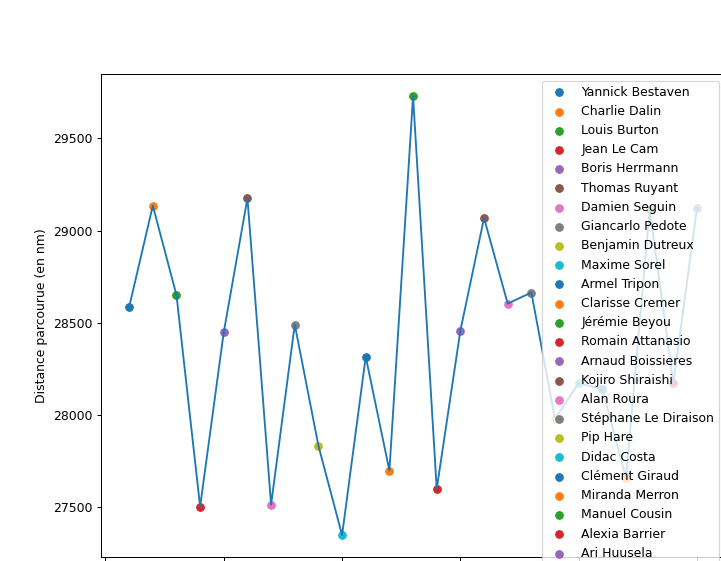

A première vue, il ne semble pas avoir de lien entre la distance parcourue et le rang du participant


In [23]:
show_rang_distance()

### Cartes avec les routes d'un ou plusieurs voiliers

In [24]:
skippers = [('Yannick Bestaven', 'green'), ('Charlie Dalin', 'red'), ('Louis Burton', 'yellow')]

def show_map(skippers):
    m = Map(center = (42.5, -41), zoom =2)
    
    output_with_data = pd.read_excel('output_with_data.xlsx')
    output_run = output_with_data.loc[(output_with_data['Statut'] == 'En cours'), ['Participant', 'Latitude', 'Longitude']]  
    for skipper in skippers:
        arr = output_run.loc[output_run['Participant'] == skipper[0], ['Latitude', 'Longitude']].values
        deltas_x = np.abs(arr[1:,1] - arr[:-1,1])
        split_idx = np.where(deltas_x > 100)[0][0] + 1
        arr1 = arr[:split_idx,:]
        arr2 = arr[split_idx:,:]
        
        line = Polyline(locations=[arr1.tolist(), arr2.tolist()], color=skipper[1], fill=False)
        m.add_layer(line)
        print(f'{skipper[1]} : {skipper[0]}')
    
    return m    

In [25]:
show_map(skippers=skippers)

green : Yannick Bestaven
red : Charlie Dalin
yellow : Louis Burton


Map(center=[42.5, -41], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

### Analyses de séries temporelles

In [26]:
skippers = ['Yannick Bestaven', 'Charlie Dalin', 'Alexia Barrier']

def time_series(skippers):
    output_with_data = pd.read_excel('output_with_data.xlsx')
    output_run = output_with_data.loc[(output_with_data['Statut'] == 'En cours'), ['Participant', 'VMG en kts (24h)', 'Date']]  
    
    plt.figure(2, figsize=(9, 7))
    
    for skipper in skippers:
        output_skipper = output_run.loc[output_run['Participant'] == skipper, ['VMG en kts (24h)', 'Date']]
        plt.plot(output_skipper['Date'], output_skipper['VMG en kts (24h)'], label=skipper) 
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('Vitesse utile (en kts)')
    plt.legend(loc='upper right')
    plt.plot()
    
    print('Yannick Bestaven et Charlie Dalin, tous deux en tête du classement, ont des performances semblables en terme de vitesse utile tout au long de la série temporelle.')
    print('Aliexia Barrier, en fin de classement, a été presque constamment en dessous de leurs vitesses utile ce qui a très certainement joué un impact dans son rang. ')

<IPython.core.display.Javascript object>


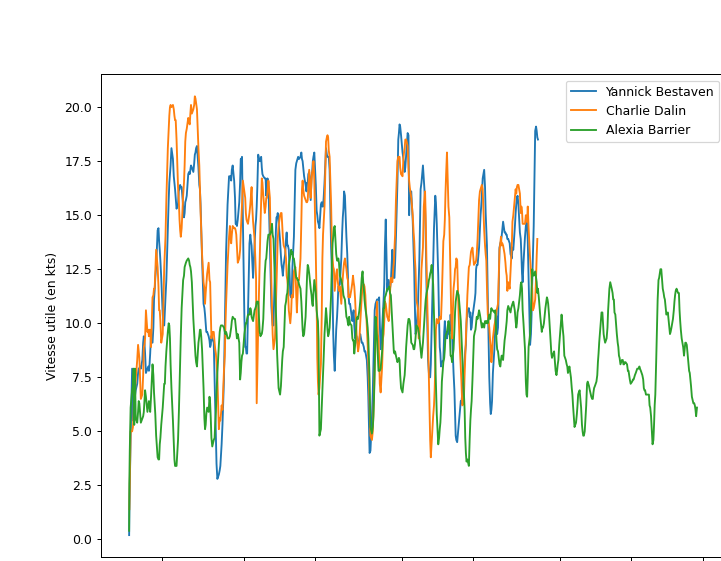

Yannick Bestaven et Charlie Dalin, tous deux en tête du classement, ont des performances semblables en terme de vitesse utile tout au long de la série temporelle.
Aliexia Barrier, en fin de classement, a été presque constamment en dessous de leurs vitesses utile ce qui a très certainement joué un impact dans son rang. 


In [27]:
time_series(skippers=skippers)

In [28]:
import os

os.system('jupyter nbconvert --to html Projet.ipynb')

0